Анализ изображений и видео, 2

Лабораторная работа №8.

Гронский Дмитрий, CS

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

Populating the interactive namespace from numpy and matplotlib


# Оценка фундаментальной матрицы 

In [2]:
from scipy.io import loadmat

In [3]:
estimate_F = loadmat('estimateF.mat')
estimate_F.keys()

['x', '__version__', '__header__', '__globals__']

In [4]:
x = estimate_F['x']
print x.shape

(2L, 1L)


In [5]:
points_1 = x[0][0]
points_2 = x[1][0]
print points_1[:, 0]

[ 145.56  466.02    1.  ]


In [6]:
N1 = np.array([[1./np.std(points_1[0, :]), 0., -np.mean(points_1[0, :])/np.std(points_1[0, :])],
              [0., 1/np.std(points_1[1, :]), -np.mean(points_1[1, :])/np.std(points_1[1, :])],
              [0., 0., 1.]])
N2 = np.array([[1./np.std(points_2[0, :]), 0., -np.mean(points_2[0, :])/np.std(points_2[0, :])],
              [0., 1/np.std(points_2[1, :]), -np.mean(points_2[1, :])/np.std(points_2[1, :])],
              [0., 0., 1.]])

In [7]:
points_1_normed = N1.dot(points_1)
points_2_normed = N2.dot(points_2)

In [8]:
A = np.empty((0, 9))
for i in xrange(points_1_normed.shape[1]):
    A = np.vstack((A, np.array([points_1_normed[0, i]*points_2_normed[0, i],
                              points_1_normed[0, i]*points_2_normed[1, i],
                              points_1_normed[0, i],
                              points_1_normed[1, i]*points_2_normed[0, i],
                              points_1_normed[1, i]*points_2_normed[1, i],
                              points_1_normed[1, i],
                              points_2_normed[0, i],
                              points_2_normed[1, i],
                              1.])))

In [9]:
from scipy.linalg import svd

### вычисленная фундаментальная матрица

In [10]:
_, _, Vt = svd(A)
F = Vt[-1, :].reshape((3, 3)) / Vt[-1, -1]
F = np.dot(N1.T, np.dot(F, N2))
U, S, Vt = svd(F)
S[-1] = 0.
F = np.dot(U, np.dot(np.diagflat(S), Vt))
F /= F[2, 2]
print F

[[ -3.69683236e-08   4.71090841e-06  -7.25256301e-03]
 [ -3.75631955e-06   2.91847530e-07   2.65486848e-02]
 [  5.83791849e-03  -2.69334621e-02   1.00000000e+00]]


### эпиполярные линии

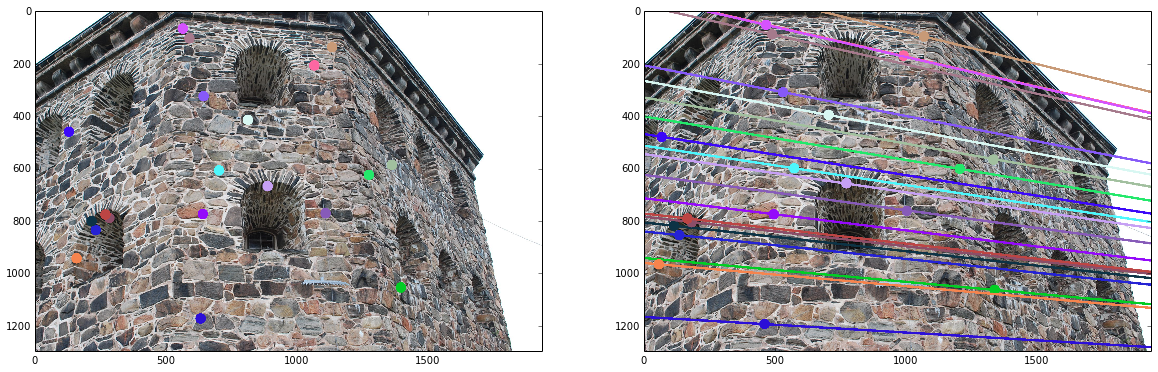

In [11]:
image_1 = np.array(cv2.imread('im1.jpg')[:, :, ::-1])
image_2 = np.array(cv2.imread('im2.jpg')[:, :, ::-1])
projection = F.T.dot(points_1)

rand_points = np.random.randint(0, len(points_1[0]), 20)
for i in rand_points:
    color = tuple(np.random.randint(0,255,3).tolist())
    w = image_2.shape[1]
    n = projection[:, i]
    x0, y0 = map(int, [0, -n[2]/n[1]])
    x1, y1 = map(int, [w, -(n[2] + n[0] * w) / n[1]])
    cv2.line(image_2, (x0, y0), (x1, y1), color, 8)
    pt1 = points_1[:, i].astype(int)
    pt2 = points_2[:, i].astype(int)
    cv2.circle(image_2, tuple(pt2[:2]), 20, color, -1)
    cv2.circle(image_1, tuple(pt1[:2]), 20, color, -1)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image_1)
plt.subplot(122)
plt.imshow(image_2)

# Оценка матрицы камеры

In [12]:
b = np.dot(np.linalg.inv(F.T[:2, :2]), -F.T[:2, -1])
b = np.concatenate((b, [1]))
print F.T.dot(b)

[  0.00000000e+00   0.00000000e+00   4.50750548e-14]


In [13]:
bx = np.asarray([[0, -b[2], b[1]], 
                 [b[2], 0, -b[0]], 
                 [-b[1], b[0], 0]])
A = -bx.dot(F)
Ab = np.hstack((A, b[:, np.newaxis]))
print 'P2 = [A|b] = '
print Ab

P2 = [A|b] = 
[[ -8.74991029e+00   4.03680315e+01  -1.49877933e+03   5.62440129e+03]
 [  3.28347963e+01  -1.51484604e+02   5.62440854e+03   1.49880587e+03]
 [  2.10716402e-02   5.41926958e-03  -1.60190641e+02   1.00000000e+00]]


# Триангуляция 

In [14]:
P1 = np.array([[1., 0., 0., 0.],
               [0., 1., 0., 0.],
               [0., 0., 1., 0.]])
P2 = Ab

In [15]:
points_3d = []
for i in xrange(points_1.shape[1]):
    A = np.empty((0, 4))
    A = np.vstack((A, points_1[0, i] * P1[2, :] - P1[0, :]))
    A = np.vstack((A, points_1[1, i] * P1[2, :] - P1[1, :]))
    A = np.vstack((A, points_2[0, i] * P2[2, :] - P2[0, :]))
    A = np.vstack((A, points_2[1, i] * P2[2, :] - P2[1, :]))
    
    _, _, Vt = svd(A)
    coord = Vt[-1, :] / Vt[-1, -1]
    points_3d.append(coord)
points_3d = np.asarray(points_3d)

In [16]:
from mpl_toolkits.mplot3d import Axes3D

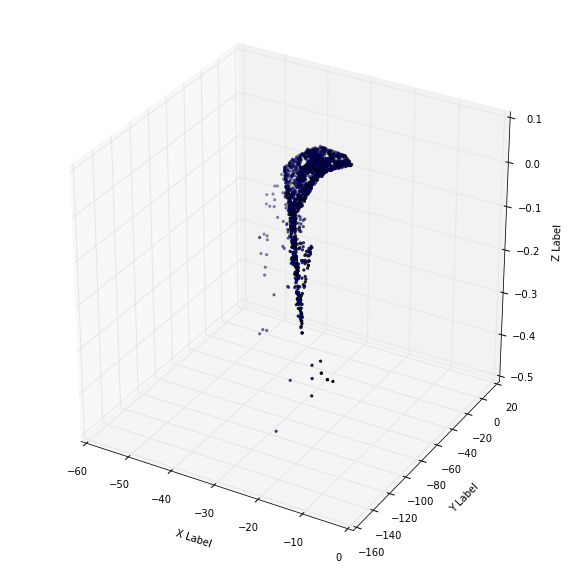

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2], c='b', marker='.')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Проверим, что координаты найдеы правильно

## Проекции на картинки

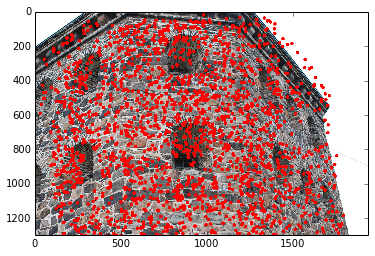

In [18]:
projection_1 = P1.dot(points_3d.T)
projection_1 = projection_1[:2, :] / projection_1[2, :]
image_1 = np.array(cv2.imread('im1.jpg')[:, :, ::-1])

for i in xrange(projection_1.shape[1]):
    cv2.circle(image_1, tuple(projection_1[:, i].astype(int)), 10, (255, 0, 0), -1)
plt.imshow(image_1)

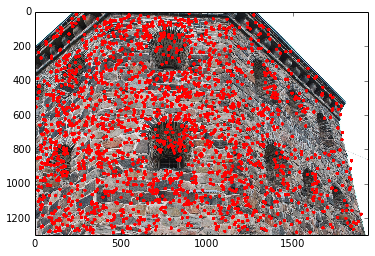

In [19]:
projection_2 = P2.dot(points_3d.T)
projection_2 = projection_2[:2, :] / projection_2[2, :]
image_2 = np.array(cv2.imread('im2.jpg')[:, :, ::-1])

for i in xrange(projection_2.shape[1]):
    cv2.circle(image_2, tuple(projection_2[:, i].astype(int)), 10, (255, 0, 0), -1)
plt.imshow(image_2)

Вторая картинка совместилась хорошо, у первыой видны "вылезшие точки"